In [35]:
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from requests import head
import numpy as np
from umap import UMAP
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from bertopic import BERTopic
from nltk import word_tokenize          
import re
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xpetr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
data= pd.read_excel("data_emails.xlsx")

In [37]:
head = data.head(3)
styled_head = head.style.set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left'), ('font-size', '12pt')]}, #colums
     {'selector': 'td', 'props': [('text-align', 'left'), ('font-size', '10pt')]}] # text
)
display(styled_head)

,subject,sender,message,message_clean
0,Mercury Language Documentation Issue,john.doe@example.com,"Hi Aetheros Support, I'm having trouble finding clear documentation on how to implement custom error handling in Mercury. The examples in the current documentation seem outdated and don't align with the latest version I'm using. Could you please point me to the correct resources or provide some guidance on this? Thanks, John Doe",aethero support trouble find clear documentation implement custom error handle mercury example current documentation outdate align late version use point correct resource provide guidance this thank john doe
1,URGENT: User Permission Errors in Production API,kenneth77@davis-becker.com,We are experiencing critical issues with user permissions on our production API (API key: aeth-prod-28374). Users with the correct roles are being denied access to endpoints they should have access to. This is causing major disruption to our services. We need immediate assistance to resolve this. We believe the issue might be related to recent changes we made in the IAM service regarding role assignments. We can provide more details on the specific roles and endpoints affected if needed.,experience critical issue user permission production api api key aeth prod user correct role deny access endpoint access to cause major disruption service assistance resolve this issue iam service role assignment provide detail specific role endpoint need
2,URGENT: Mercury Code Deployment Failing with Error 502,john.doe@example.com,"Hi Aetheros Support, We are experiencing urgent issues deploying our Mercury code to production. We are consistently getting a 502 error, and our API monitoring dashboard is showing a spike in errors. This is causing a major outage for our services. We have checked our code and cannot identify the issue. Can you please investigate ASAP? Thanks, John Doe",aethero support experience urgent issue deploy mercury code production consistently error api monitor dashboard show spike error cause major outage service check code identify issue investigate asap thanks john doe


In [38]:
# 1. BERTopic, training
# Create a list of speeches

docs = data['message'].tolist()

In [39]:
## Create a preprocessing class retrurning lemmatized text without numbers

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        doc = re.sub(r'\d+', '', doc)    #remove numbers
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [40]:
# extended list of English stopwords
stopwords_extended = [
"0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about",
 "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually",
 "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards",
 "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost",
 "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst",
 "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone",
 "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear",
 "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't",
 "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au",
 "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1",
 "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes",
 "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins",
 "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between",
 "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br",
 "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca",
 "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce",
 "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly",
 "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently",
 "consider", "considering", "contain", "containing", "contains", "corresponding",
 "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's",
 "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de",
 "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't",
 "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't",
 "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3",
 "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either",
 "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough",
 "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu",
 "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex",
 "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi",
 "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl",
 "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth",
 "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further",
 "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give",
 "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten",
 "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly",
 "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd",
 "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres",
 "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself",
 "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr",
 "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid",
 "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm",
 "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed",
 "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead",
 "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it",
 "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj",
 "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know",
 "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter",
 "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's",
 "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look",
 "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly",
 "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile",
 "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml",
 "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu",
 "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely",
 "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn",
 "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine",
 "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor",
 "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt",
 "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often",
 "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one",
 "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others",
 "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over",
 "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount",
 "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per",
 "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po",
 "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present",
 "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt",
 "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran",
 "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref",
 "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl",
 "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn",
 "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say",
 "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem",
 "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously",
 "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's",
 "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side",
 "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl",
 "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something",
 "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically",
 "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly",
 "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure",
 "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td",
 "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that",
 "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves",
 "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein",
 "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've",
 "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv",
 "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though",
 "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus",
 "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top",
 "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying",
 "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d",
 "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike",
 "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used",
 "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va",
 "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol",
 "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was",
 "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll",
 "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what",
 "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's",
 "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon",
 "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever",
 "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi",
 "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder",
 "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www",
 "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv",
 "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your",
 "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt",
 "z", "zero", "zi", "zz"]

In [41]:
# create standard stopwords list
standard_stopwords = list(stopwords.words('english'))
# add additional stopwords
additional_stopwords = ['hi',"john","doe",'aetheros','support','isabella','rodriguez','team']

# combine standard, extended stopwords, and additional tokens
full_stopwords = standard_stopwords + additional_stopwords + stopwords_extended

# vectorizer makes data processing and generates bigrams
vectorizer_model = CountVectorizer(tokenizer=LemmaTokenizer(),
                                  ngram_range=(2, 2),
                                  stop_words=full_stopwords)

In [42]:
# Model training
topic_size  = 9
top_n_words = 15

# set-up model         
model = BERTopic(n_gram_range=(2,2),                # returns bigrams
                nr_topics=topic_size,               # generate 8 topics, leave -1 for outliers
                top_n_words=top_n_words,            # return top 15 bigrams
                min_topic_size=20,                  # each topic contains at least 20 tokens
                vectorizer_model=vectorizer_model,
                umap_model = UMAP(random_state=1))  # setting seed topics reproduce

# fit model to data
topics, probabilities = model.fit_transform(docs)

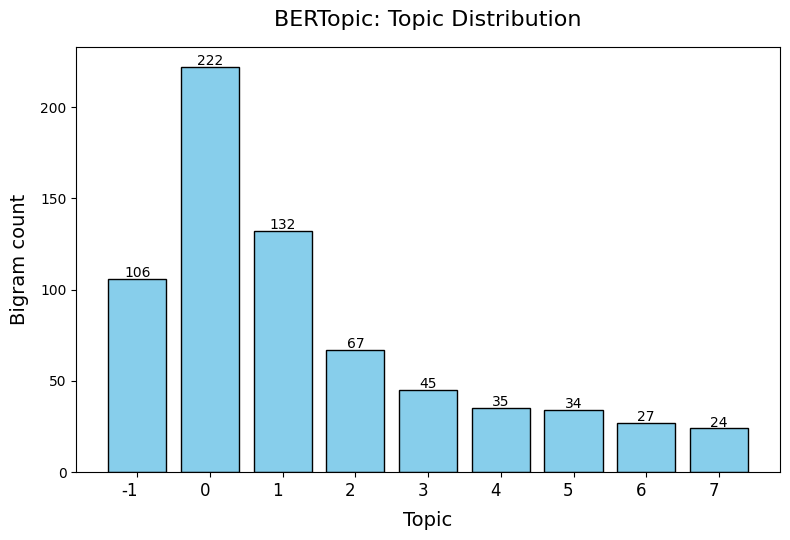

In [43]:
# 2. BERTopic, topic distribution for a T8 model

# Get topic information
topic_info = model.get_topic_info()

# Sort the DataFrame by Topic number instead of Count
topic_info_sorted = topic_info.sort_values(by='Topic', ascending=True)

# Plot histogram using sorted values
plt.figure(figsize=(8, 5.5))
bars = plt.bar(topic_info_sorted['Topic'].astype(str), topic_info_sorted['Count'], 
               color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Topic', fontsize=14, labelpad=8)
plt.ylabel('Bigram count', fontsize=14, labelpad=8) 
plt.title('BERTopic: Topic Distribution', fontsize=16, pad=15)

# Rotate x-axis labels for better readability
plt.xticks(fontsize=12, ha='right')

# Add value labels on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
             str(int(bar.get_height())), ha='center', fontsize=10)

# Save the plot with 400 DPI
plt.tight_layout()
plt.savefig('BERT_topic_distribution.png', dpi=400)

# Show the plot
plt.show()

In [44]:
# 3. BERTopic, display top words in a dataframe

topic_outliers = pd.DataFrame(model.get_topic(-1), columns=["T-1", "Prob_-1"])
topic_0 = pd.DataFrame(model.get_topic(0), columns=["T0", "Prob_0"])
topic_1 = pd.DataFrame(model.get_topic(1), columns=["T1", "Prob_1"])
topic_2 = pd.DataFrame(model.get_topic(2), columns=["T2", "Prob_2"])
topic_3 = pd.DataFrame(model.get_topic(3), columns=["T3", "Prob_3"])
topic_4 = pd.DataFrame(model.get_topic(4), columns=["T4", "Prob_4"])
topic_5 = pd.DataFrame(model.get_topic(5), columns=["T5", "Prob_5"])
topic_6 = pd.DataFrame(model.get_topic(6), columns=["T6", "Prob_6"])
topic_7 = pd.DataFrame(model.get_topic(7), columns=["T7", "Prob_7"])
# topic_8 = pd.DataFrame(model.get_topic(8), columns=["T8", "Prob_8"])
# topic_9 = pd.DataFrame(model.get_topic(9), columns=["T9", "Prob_9"])

topics_df = pd.concat([topic_outliers,topic_0, topic_1, topic_2, topic_3, topic_4,topic_5,topic_6, topic_7], axis=1)
# topics_df = pd.concat([topic_outliers,topic_0, topic_1, topic_2, topic_3, topic_4,topic_5,topic_6, topic_7,topic_8, topic_9], axis=1)


# Keep only predicted bigrams, leave out probabilities
topics_df = topics_df.loc[:, topics_df.columns.str.startswith('T')]
topics_df

,T-1,T0,T1,T2,T3,T4,T5,T6,T7
0,cloud management,iam service,api monitoring,mercury language,deploying mercury,peak hour,business operation,mercury language,api development
1,rate limiting,iam role,response time,error message,mercury application,scaling cloud,experiencing complete,project mercury,development service
2,api development,critical issue,latency spike,error handling,issue deploying,cloud resource,environment hosted,working project,interested learning
3,issue api,role permission,monitoring dashboard,compiler error,deployment process,weve experiencing,impacting business,asyncawait syntax,ecommerce platform
4,api gateway,experiencing critical,weve experiencing,production environment,application cloud,difficulty scaling,estimated time,asyncawait mercury,cloud management
5,rate limit,issue iam,issue api,experiencing critical,error message,cloud management,time resolution,handle asynchronous,time consideration
6,advise step,user role,api developed,error mercury,trouble deploying,management service,production environment,addition mercury,platform interested
7,response time,access resource,monitoring service,critical issue,cloud management,experiencing difficulty,hosted cloud,unexpected behavior,learning api
8,api monitoring,unable access,spike api,unexpected token,resource limit,application experience,resolution production,asynchronous operation,consideration sincerely
9,critical issue,api endpoint,intermittent latency,resolve issue,application aws,platform application,asap production,concurrent request,inventory management


In [ ]:
topics_df.to_excel('BERTopic_8_TOP_15.xlsx', index=False)

In [46]:
# 4. Coherence evaluation
# 4.1. NPMI
NPMI = pd.read_csv('NPMI_mailing.csv')

In [ ]:
# Merge bigrams predicted by FASTopic and BERTopic with their NPMI scores from the reference corpus. The fewer NaNs are in the table, the more accurate the metric is.

topics_df = pd.merge(topics_df, NPMI, left_on='T0', right_on='bigram', how='left')
topics_df = pd.merge(topics_df, NPMI, left_on='T0', right_on='bigram_synonym', how='left')

topics_df['npmi'] = topics_df['npmi_x'].fillna(topics_df['npmi_y'])
topics_df.drop(columns=['npmi_x', 'npmi_y','bigram_x','bigram_synonym_x','bigram_y','bigram_synonym_y'], inplace=True)
topics_df.rename(columns={'npmi': 'NPMI_T0'}, inplace=True)

In [48]:
topics_df = pd.merge(topics_df, NPMI, left_on='T1', right_on='bigram', how='left')
topics_df = pd.merge(topics_df, NPMI, left_on='T1', right_on='bigram_synonym', how='left')

topics_df['npmi'] = topics_df['npmi_x'].fillna(topics_df['npmi_y'])
topics_df.drop(columns=['npmi_x', 'npmi_y','bigram_x','bigram_synonym_x','bigram_y','bigram_synonym_y'], inplace=True)
topics_df.rename(columns={'npmi': 'NPMI_T1'}, inplace=True)

In [49]:
topics_df = pd.merge(topics_df, NPMI, left_on='T2', right_on='bigram', how='left')
topics_df = pd.merge(topics_df, NPMI, left_on='T2', right_on='bigram_synonym', how='left')

topics_df['npmi'] = topics_df['npmi_x'].fillna(topics_df['npmi_y'])
topics_df.drop(columns=['npmi_x', 'npmi_y','bigram_x','bigram_synonym_x','bigram_y','bigram_synonym_y'], inplace=True)
topics_df.rename(columns={'npmi': 'NPMI_T2'}, inplace=True)

In [50]:
topics_df = pd.merge(topics_df, NPMI, left_on='T3', right_on='bigram', how='left')
topics_df = pd.merge(topics_df, NPMI, left_on='T3', right_on='bigram_synonym', how='left')

topics_df['npmi'] = topics_df['npmi_x'].fillna(topics_df['npmi_y'])
topics_df.drop(columns=['npmi_x', 'npmi_y','bigram_x','bigram_synonym_x','bigram_y','bigram_synonym_y'], inplace=True)
topics_df.rename(columns={'npmi': 'NPMI_T3'}, inplace=True)

In [51]:
topics_df = pd.merge(topics_df, NPMI, left_on='T4', right_on='bigram', how='left')
topics_df = pd.merge(topics_df, NPMI, left_on='T4', right_on='bigram_synonym', how='left')

topics_df['npmi'] = topics_df['npmi_x'].fillna(topics_df['npmi_y'])
topics_df.drop(columns=['npmi_x', 'npmi_y','bigram_x','bigram_synonym_x','bigram_y','bigram_synonym_y'], inplace=True)
topics_df.rename(columns={'npmi': 'NPMI_T4'}, inplace=True)

In [52]:
topics_df = pd.merge(topics_df, NPMI, left_on='T5', right_on='bigram', how='left')
topics_df = pd.merge(topics_df, NPMI, left_on='T5', right_on='bigram_synonym', how='left')

topics_df['npmi'] = topics_df['npmi_x'].fillna(topics_df['npmi_y'])
topics_df.drop(columns=['npmi_x', 'npmi_y','bigram_x','bigram_synonym_x','bigram_y','bigram_synonym_y'], inplace=True)
topics_df.rename(columns={'npmi': 'NPMI_T5'}, inplace=True)

In [53]:
topics_df = pd.merge(topics_df, NPMI, left_on='T6', right_on='bigram', how='left')
topics_df = pd.merge(topics_df, NPMI, left_on='T6', right_on='bigram_synonym', how='left')

topics_df['npmi'] = topics_df['npmi_x'].fillna(topics_df['npmi_y'])
topics_df.drop(columns=['npmi_x', 'npmi_y','bigram_x','bigram_synonym_x','bigram_y','bigram_synonym_y'], inplace=True)
topics_df.rename(columns={'npmi': 'NPMI_T6'}, inplace=True)

In [54]:
topics_df = pd.merge(topics_df, NPMI, left_on='T7', right_on='bigram', how='left')
topics_df = pd.merge(topics_df, NPMI, left_on='T7', right_on='bigram_synonym', how='left')

topics_df['npmi'] = topics_df['npmi_x'].fillna(topics_df['npmi_y'])
topics_df.drop(columns=['npmi_x', 'npmi_y','bigram_x','bigram_synonym_x','bigram_y','bigram_synonym_y'], inplace=True)
topics_df.rename(columns={'npmi': 'NPMI_T7'}, inplace=True)

In [55]:
# topics_df = pd.merge(topics_df, NPMI, left_on='T8', right_on='bigram', how='left')
# topics_df = pd.merge(topics_df, NPMI, left_on='T8', right_on='bigram_synonym', how='left')

# topics_df['npmi'] = topics_df['npmi_x'].fillna(topics_df['npmi_y'])
# topics_df.drop(columns=['npmi_x', 'npmi_y','bigram_x','bigram_synonym_x','bigram_y','bigram_synonym_y'], inplace=True)
# topics_df.rename(columns={'npmi': 'NPMI_T8'}, inplace=True)

In [56]:
# topics_df = pd.merge(topics_df, NPMI, left_on='T9', right_on='bigram', how='left')
# topics_df = pd.merge(topics_df, NPMI, left_on='T9', right_on='bigram_synonym', how='left')

# topics_df['npmi'] = topics_df['npmi_x'].fillna(topics_df['npmi_y'])
# topics_df.drop(columns=['npmi_x', 'npmi_y','bigram_x','bigram_synonym_x','bigram_y','bigram_synonym_y'], inplace=True)
# topics_df.rename(columns={'npmi': 'NPMI_T9'}, inplace=True)

In [57]:
topics_df.head(15)

,T-1,T0,T1,T2,T3,T4,T5,T6,T7,NPMI_T0,NPMI_T1,NPMI_T2,NPMI_T3,NPMI_T4,NPMI_T5,NPMI_T6,NPMI_T7
0,cloud management,iam service,api monitoring,mercury language,deploying mercury,peak hour,business operation,mercury language,api development,NaN,NaN,NaN,NaN,0.833381,0.271596,NaN,NaN
1,rate limiting,iam role,response time,error message,mercury application,scaling cloud,experiencing complete,project mercury,development service,NaN,0.323179,0.426962,NaN,NaN,NaN,NaN,0.239503
2,api development,critical issue,latency spike,error handling,issue deploying,cloud resource,environment hosted,working project,interested learning,0.093769,0.529934,0.153264,NaN,-0.007154,NaN,0.173470,0.623674
3,issue api,role permission,monitoring dashboard,compiler error,deployment process,weve experiencing,impacting business,asyncawait syntax,ecommerce platform,0.496296,NaN,NaN,NaN,NaN,0.050966,NaN,0.355942
4,api gateway,experiencing critical,weve experiencing,production environment,application cloud,difficulty scaling,estimated time,asyncawait mercury,cloud management,NaN,NaN,NaN,0.056150,NaN,NaN,NaN,0.087653
5,rate limit,issue iam,issue api,experiencing critical,error message,cloud management,time resolution,handle asynchronous,time consideration,NaN,0.086288,NaN,0.426962,0.087653,0.025870,NaN,0.182260
6,advise step,user role,api developed,error mercury,trouble deploying,management service,production environment,addition mercury,platform interested,0.234146,NaN,NaN,NaN,0.005525,NaN,NaN,0.046977
7,response time,access resource,monitoring service,critical issue,cloud management,experiencing difficulty,hosted cloud,unexpected behavior,learning api,-0.155931,-0.023928,0.093769,0.087653,0.219860,NaN,0.018576,-0.084324
8,api monitoring,unable access,spike api,unexpected token,resource limit,application experience,resolution production,asynchronous operation,consideration sincerely,0.202503,NaN,NaN,0.166298,0.068573,NaN,NaN,0.172406
9,critical issue,api endpoint,intermittent latency,resolve issue,application aws,platform application,asap production,concurrent request,inventory management,0.022925,NaN,0.362632,NaN,-0.044887,NaN,NaN,0.241341


In [58]:
# Calculate means for each NPMI column
NPMI_topics = topics_df[['NPMI_T0', 'NPMI_T1', 'NPMI_T2', 'NPMI_T3', 'NPMI_T4', 'NPMI_T5', 'NPMI_T6', 'NPMI_T7']].mean()
# NPMI_topics = topics_df[['NPMI_T0', 'NPMI_T1', 'NPMI_T2', 'NPMI_T3', 'NPMI_T4', 'NPMI_T5', 'NPMI_T6', 'NPMI_T7','NPMI_T8', 'NPMI_T9']].mean()

# Calculate overall NPMI
NPMI = float(format(round(NPMI_topics.mean(),3), '.3f'))
print("\nNPMI: {:.3f}".format(NPMI))


NPMI: 0.166


In [59]:
# 4.2 Semantic coherence by Mimmo et al. (2011)

In [60]:
# create a document-term matrix (DTM)
def bigram_tokenizer(text):                 # custom tokenizer to join bigrams with an underscore
    tokens = text.split()
    bigrams = [f"{tokens[i]}_{tokens[i+1]}" for i in range(len(tokens)-1)]
    return bigrams

vectorizer = CountVectorizer(tokenizer = bigram_tokenizer, ngram_range=(1, 1))

# create a DTM with count vectorizer
dtm = vectorizer.fit_transform(docs)

# create a vocabulary of bigrams
feature_names = vectorizer.get_feature_names_out()

In [61]:
# define a topic-words matrix
# join bigrams into tokens by replacing spaces with underscores in T8 BERTopic bigram table
topics_df = topics_df.applymap(lambda x: x.replace(' ', '_') if isinstance(x, str) else x)
topic_words_matrix = [topics_df[col].tolist() for col in topics_df.columns]

# convert to NumPy array and transpose for function compatibility
topic_words_matrix = np.array(topic_words_matrix).T

In [62]:
# calculate topic-level SC coherence, using the DTM and topic-words matrices

def topic_coherence(dtm, topic_words_matrix, feature_names, epsilon=1):
    topic_words_matrix = np.array(topic_words_matrix)
    coherence_scores = {}

    coherence_scores = []
    topics = []

    # Convert DTM to binary presence/absence matrix
    dtm_bin = (dtm > 0).astype(int)

    # Compute document frequency for each word (D_w)
    word_indices = {word: i for i, word in enumerate(feature_names)}
    D_w = np.array(dtm_bin.sum(axis=0)).flatten()

    # Iterate over topics
    for topic_idx in range(topic_words_matrix.shape[1]):
        topic_words = topic_words_matrix[:, topic_idx]
        coherence_score = 0.0  # Initialize coherence score 

        # Iterate over word pairs
        for i in range(1, len(topic_words)):
            for j in range(i):
                w_i, w_j = topic_words[i], topic_words[j]

                # Skip words not in vocabulary
                if w_i not in word_indices or w_j not in word_indices:
                    continue

                # Get indices for words
                idx_i, idx_j = word_indices[w_i], word_indices[w_j]

                # Compute co-occurrence (D_wi_wj)
                D_wi_wj = np.sum(dtm_bin[:, idx_i].multiply(dtm_bin[:, idx_j]))

                # Apply coherence formula
                if D_w[idx_j] > 0:
                    coherence_score += np.log((D_wi_wj + epsilon) / D_w[idx_j])

        coherence_scores.append(coherence_score)
        topics.append(topic_idx)

    return coherence_scores, topics

In [63]:
sc_topics, topics = topic_coherence(dtm, topic_words_matrix, feature_names, epsilon=1)

In [64]:
# average topic SC to a model SC score
sc_topics= pd.DataFrame(sc_topics, index=topics, columns=['score'])
SC=sc_topics['score'].mean()
print("\nSemantic Coherence: {:.2f}".format(SC))


Semantic Coherence: -38.01


In [65]:
# 5. Topic diversity evaluation, PUV (Percentage of Unique Words)
# calculate topic diversity as count of distinct tokens/ count of tokens in the tables for a model

def puv(data): 
    total_word_count = 0
    total_unique_words = set()

    for column in data.columns: 
        if column.startswith('T'): 
            all_text = ' '.join(data[column].astype(str).tolist())         
            words = all_text.split() 

            total_word_count += len(words)
            total_unique_words.update(words)

    total_unique_word_count = len(total_unique_words)
    td = round(total_unique_word_count / total_word_count, 3) if total_word_count > 0 else 0

    return td

In [67]:
TD = puv(topics_df)
print("\nTopic Diversity: {:.3f}".format(TD))


Topic Diversity: 0.822
